<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [100]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

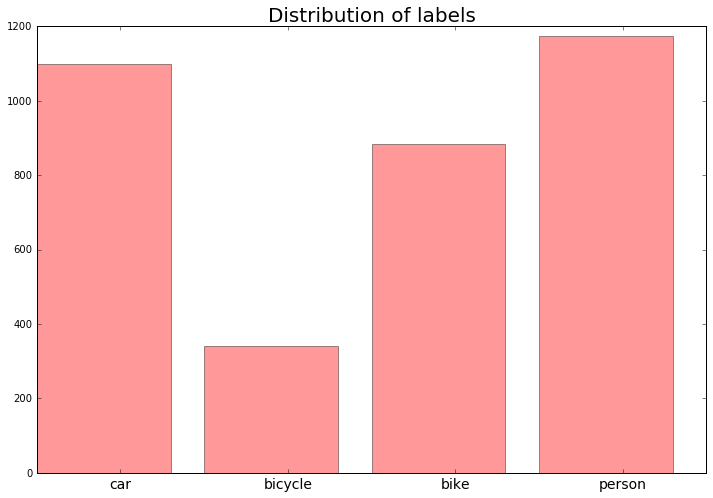

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [10]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [11]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [12]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, self.xi)
        yi = max(0, self.yi)
        xf = min(im.shape[1], self.xf)
        yf = min(im.shape[0], self.yf)
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [13]:
def generate_data(annotations, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + 4))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [14]:
net = {}
net['input'] = InputLayer((None,3,200,200))
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv6'], (2,2))
net['conv7'] = Conv2DLayer(net['pool3'], 64, (3,3))
net['conv8'] = Conv2DLayer(net['conv7'], 64, (3,3))
net['pool4'] = Pool2DLayer(net['conv8'], (2,2))
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.8), 1000)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.8), 1000)
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [15]:
with open('pretrained_weights.pkl', 'rb') as f:
    weights = pk.load(f)
    lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [16]:
S = (9,9)
B = 2
C = 4

In [17]:
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.8), 2048)
net['output'] = DenseLayer(dropout(net['dense1'], p=.8), (S[0] * S[1]) * (5 * B + C), nonlinearity=None)

In [18]:
load_weights = False
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [19]:
num_epochs = 100
batch_size = 100

In [20]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [21]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

/Library/Python/2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [22]:
train_loss, test_loss = yl.train(
    generate_data(train_annotations),
    generate_data(test_annotations),
    lr=1e-3,
    epochs=num_epochs
)

Getting cost...
Creating cost variable took 0.5351 seconds
Compiling...


  0%|          | 0/100 [00:00<?, ?it/s]

Compiling functions took 34.6626 seconds
Beginning training...
20029.4277344
66623.5234375
12313.2421875
10631.0263672
12734.7626953
50999.8632812
14348.1835938
34186.6484375
10860.921875
10050.2773438
9139.85351562
11686.6591797
10849.2080078
9358.79394531
8971.83300781
9528.38476562
8954.61328125
9049.65332031
8495.13574219
8122.80957031
7983.43994141
10384.7607422
9269.90625
13228.125
12650.4736328
8485.17382812
7992.53320312
8718.42089844
8304.82226562
9008.91601562
9358.22558594
8017.43945312
7837.99804688
7801.26708984
7767.62011719
7618.89648438
7354.56933594


  1%|          | 1/100 [03:46<6:13:18, 226.25s/it]

Epoch 0
------
Train Loss: 13208.5791, Test Loss: 6850.9888
8706.47070312
7983.95458984
8312.703125
8400.5625
7160.87695312
7429.72753906
7918.49121094
7755.15136719
7447.68701172
6680.47705078
7127.60888672
8257.29394531
8129.09082031
8102.12841797
7610.58740234
7768.82958984
7691.50878906
7956.47167969
7014.79785156
7187.54638672
6714.47167969
7228.17431641
6744.81591797
7413.49414062
7401.67822266
6941.23632812
7402.06835938
7825.51464844
7990.25537109
8010.45068359
7607.52441406
6932.83154297
6201.85009766
7113.32421875
6709.88134766
20003.3730469
7669.12304688


  2%|▏         | 2/100 [04:28<4:39:17, 170.99s/it]

Epoch 1
------
Train Loss: 7852.7578, Test Loss: 6792.0552
8036.6171875
7753.11083984
7155.03955078
7247.91455078
7842.94433594
7618.83447266
7884.31591797
7828.8359375
7374.73144531
6706.32324219
6666.00878906
7691.84814453
7361.87060547
7624.56591797
7418.84179688
7470.17333984
7787.14306641
7972.67675781
6796.80419922
6821.97412109
6890.27832031
7383.25244141
6674.22851562
7436.86523438
7270.95800781
9092.98339844
7863.93945312
7691.55029297
7238.00732422
7157.49023438
6938.05029297
6652.95800781
6533.52636719
7455.47460938
6787.84326172
6764.38037109
6468.66210938


  3%|▎         | 3/100 [05:10<3:33:54, 132.31s/it]

Epoch 2
------
Train Loss: 7334.0820, Test Loss: 6500.8003
7673.05371094
6670.91015625
6907.33056641
6944.203125
6465.46923828
6496.49072266
7440.21386719
7317.67480469
6828.875
6119.06445312
6335.93652344
7421.08789062
6886.34716797
7072.75585938
7664.33300781
7978.74023438
7742.31640625
8221.97753906
7605.81640625
6863.47851562
6588.62255859
6890.66601562
6394.27392578
7100.35449219
6912.84667969
6617.76025391
6420.03759766
6558.63427734
6375.16503906
6724.67773438
7117.95507812
6530.47705078
5695.38574219
7579.30126953
6988.80175781
6369.44384766
6276.85058594


  4%|▍         | 4/100 [05:52<2:48:22, 105.24s/it]

Epoch 3
------
Train Loss: 6913.4409, Test Loss: 6055.3784
6871.02783203
6001.39550781
6035.98583984
6447.85498047
5867.40722656
6896.58300781
6911.04833984
6585.37060547
6305.3203125
5731.38574219
5470.24121094
6722.84082031
6460.98242188
6241.98486328
6273.78808594
6811.26806641
7303.30273438
8002.02441406
6186.06445312
5983.80615234
5696.82421875
6134.0078125
6014.79492188
6773.59570312
6436.59472656
6461.28515625
6531.39697266
6119.31445312
5844.70800781
6202.39453125
6402.59667969
6044.57714844
5031.10595703
6865.03955078
5968.76855469
5652.48486328
5528.5390625


  5%|▌         | 5/100 [06:34<2:16:36, 86.28s/it] 

Epoch 4
------
Train Loss: 6292.3706, Test Loss: 5738.1885
6650.67724609
5926.67919922
5553.53955078
5675.70507812
5066.99755859
6181.85693359
6417.99707031
6071.72900391
5847.84814453
5067.35253906
5183.6640625
6743.33984375
6510.14160156
6743.54882812
7027.14648438
6015.11572266
6251.94970703
6978.3203125
5672.67382812
4864.07226562
4990.44775391
5720.53271484
5658.14794922
6132.91113281
6118.4375
6105.86865234
5974.37011719
6147.53271484
5666.36376953
5750.95507812
6014.09814453
6125.15332031
5083.3203125
6261.5625
5503.40380859
4947.39892578
4552.12304688


  6%|▌         | 6/100 [07:16<1:54:23, 73.02s/it]

Epoch 5
------
Train Loss: 5870.3516, Test Loss: 5560.9253
6122.22070312
5297.00488281
5203.96435547
5466.9609375
4807.66503906
5664.69921875
6481.20947266
5403.73974609
5847.64550781
4891.01855469
4902.52441406
5599.75195312
6291.60351562
5871.39794922
5933.93310547
6818.45166016
6009.63134766
6779.36865234
5765.27099609
4517.36767578
4712.8515625
5313.11621094
5226.19384766
5808.79492188
5740.41308594
4996.01953125
4974.05126953
5373.70751953
5054.7734375
5299.89941406
5468.6484375
5424.12451172
4487.02197266
6046.84667969
4671.21923828
4513.57568359
4212.73144531


  7%|▋         | 7/100 [07:58<1:38:46, 63.73s/it]

Epoch 6
------
Train Loss: 5432.4170, Test Loss: 5395.8169
5995.19921875
5207.38378906
5397.54980469
5571.34814453
5171.86425781
5592.87939453
5853.29199219
5112.80175781
5399.19970703
4577.42626953
4776.24609375
5226.44921875
5173.125
5284.23925781
5199.32958984
4878.21337891
5459.06494141
6493.83203125
5253.70410156
4219.27978516
4646.1328125
5206.46386719
5075.23388672
5790.47070312
5401.23388672
5116.68359375
5504.515625
5840.23291016
4955.85839844
5452.37158203
5718.61181641
4904.71533203
4181.40136719
5869.94726562
5024.82470703
4555.23486328
4440.04980469


  8%|▊         | 8/100 [08:40<1:27:44, 57.23s/it]

Epoch 7
------
Train Loss: 5230.4438, Test Loss: 5251.5474
5850.81298828
4498.55419922
4647.67871094
4479.77832031
4219.76953125
4445.22412109
5169.828125
4633.76074219
5334.17773438
4399.56689453
4314.83496094
5280.26660156
5266.24511719
5653.39453125
5403.53027344
5265.64355469
5310.61523438
6154.79394531
5377.39892578
4077.51367188
4055.13330078
4795.32568359
5129.48046875
5942.21728516
4835.32763672
5131.30859375
4937.67089844
4881.33349609
4696.66503906
4478.82373047
4921.61621094
5551.0234375
4268.58398438
5018.66015625
4145.76904297
4423.21679688
4081.21630859


  9%|▉         | 9/100 [09:22<1:19:53, 52.67s/it]

Epoch 8
------
Train Loss: 4893.9663, Test Loss: 5159.5029
5116.97753906
4606.74121094
4842.81982422
4202.74560547
3976.26635742


In [23]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [24]:
train_loss_total, test_loss_total = train_loss, test_loss
# train_loss_total = np.concatenate((train_loss_total, train_loss))
# test_loss_total = np.concatenate((test_loss_total, test_loss))

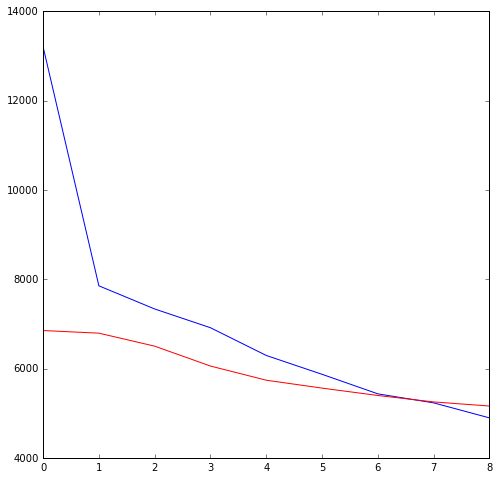

In [25]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [26]:
gen = generate_data(test_annotations[np.random.random_integers(0, test_annotations.size - 1, size=(100,))])

In [27]:
testdat = [t for t in gen]

In [28]:
Xtest, ytest = testdat[0]

In [29]:
out_fn = theano.function([yl.input], yl.output_test)

In [30]:
Xtest_out = out_fn(Xtest)

In [31]:
def draw_best(im, output):
    idx = (output[[4,9]] * output[-4:].max(axis=0,keepdims=True)).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(coord[0] * im.shape[1] + 1./9 * idx[2])
    yi = int(coord[1] * im.shape[0] + 1./9 * idx[1])
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])

    xi, yi = max(0, xi), max(0, yi)
    xf, yf = max(im.shape[1]-1 , 0), max(im.shape[0]-1, 0)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]

    return draw_im, obj_score, class_score

In [32]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [33]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [97]:
N = int(Xtest.shape[0] * np.random.rand())
print N

79


In [98]:
a,b,c = draw_best(swap(Xtest[N]), Xtest_out[N])

bicycle with class score: 0.509, objectness: 0.137
[ 0.09961911  0.5094291   0.07087747  0.32007432]
[ 0.28593752  0.3729167   0.06093749  0.3125      0.          0.          0.
  1.        ]


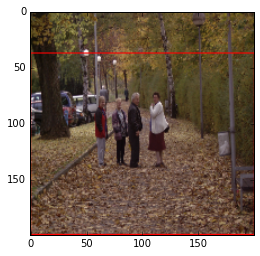

In [99]:
plt.imshow(a)
print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
print c
print ytest[N]

In [213]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [214]:
im2 = rgb2hsv(im)

In [215]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

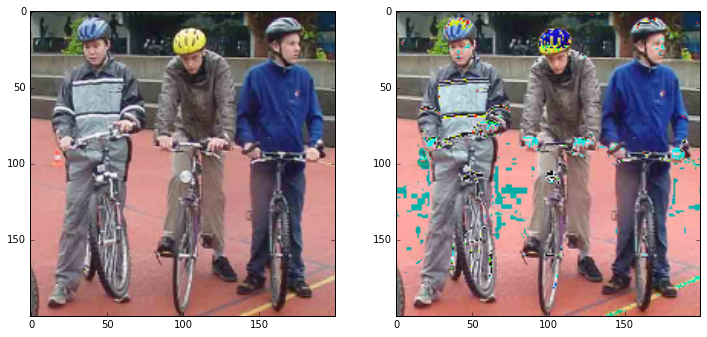

In [216]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [157]:
im3 = hsv2rgb(im2)